0   1087.1526113671275
1   1182.5500000000002
2   1160.9660130718953
3   1205.7
4   1112.9499999999998
5   1143.0716732026142
6   1157.2697773244943
7   1150.0338065896449
8   1206.6520162601626
9   1157.25


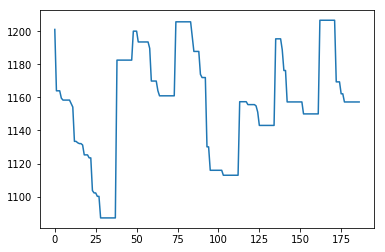

In [25]:
from workflow import *
import networkx as nx
import random
import matplotlib.pyplot as plt
from pilp import *
import time

def init_avail(cores):
    avail = {}
    for i in range(1, cores + 1):
        avail["Core{}".format(i)] = 0
    return avail


# formula-5
def fD(nd, dag):
    if not list(dag.predecessors(nd)):
        return 1
    else:
        res = 0
        for pre in list(dag.predecessors(nd)):
            res += fD(pre, dag)
        return res


# formula-6
def bD(nd, dag):
    if not list(dag.successors(nd)):
        return 1
    else:
        res = 0
        for su in list(dag.successors(nd)):
            res += bD(su, dag)
        return res


# formula-7
def fFD(nd, dag, visit, FD):
    res = 0
    for pre in list(dag.predecessors(nd)):
#         if pre not in visit:
#             res += FD[pre]
            res += FD[pre]
    return res


# formula-8
def fBD(nd, dag, visit, BD):
    res = 0
    a = list(dag.successors(nd))
    for su in a:
        res += BD[su]
    return res


# formula-9
def compute_yita(i, li, nodes, dag, S, BD, FD):
    yita = {}
    yita_i = {}
    for j in nodes:
        if i != j and j in li:
            bd = fBD(j, dag, S, BD)
            fd = fFD(j, dag, S, FD)
#             fd = FD[j]
#             yita_i[j] = bd / fd
            yita_i[j] = bd / len(nodes)
#             yita_i[j] = bd 
        else:
            yita_i[j] = 0
    yita[i] = yita_i
    return yita


# formula-11
def compute_p(i, li, nodes, phero, yita, alpha):
    p = {}
    sigma = 0
    for j in li:
        sigma +=  phero[i][j] * (yita[i][j] ** alpha)
    p_i = {}
    for j in nodes:
        if j == i or (j not in li):
            if (i not in p.keys()) or (j not in p[i].keys()):
                p_i[j] = 0
        else:
            p_i[j] = phero[i][j] * (yita[i][j] ** alpha) / sigma
    p[i] = p_i
    return p


# init the pheromone in a random schedule
def init_phero(dag, platform):
    nodes = list(nx.topological_sort(dag))
    avail = init_avail(nx.number_of_nodes(platform))
    ready, AFT, AST, phero, m = {}, {}, {}, {}, {}

    # a random schedule to caculate the pheromone_0
    for nd in nodes:
        core = random.randint(1, nx.number_of_nodes(platform))
        m[nd] = "Core{}".format(core)

        temp = [0]
        for pre in list(dag.predecessors(nd)):
            if m[pre] != m[nd]:
                temp.append(AFT[pre] + dag[pre][nd]['data'] / platform[m[pre]][m[nd]]['bandwidth'])
            else:
                temp.append(AFT[pre])
        ready[nd] = max(temp)

        AST[nd] = max(ready[nd], avail["Core{}".format(core)])
        avail["Core{}".format(core)] = AST[nd] + dag.node[nd]["Core{}".format(core)]
        AFT[nd] = AST[nd] + dag.node[nd]["Core{}".format(core)]


    # init the pheromone, all the path
    n = len(nodes)
    for i in nodes:
        phero_i = {}
        for j in nodes:
            if i != j:
                phero_i[j] = 1 / (n * (n - 1))
            else:
                phero_i[j] = 0
        phero[i] = phero_i

    return 1 / (AFT['des'] * nx.number_of_nodes(dag)), phero


def all_pre_visit(nd, dag, S):
    flag = 1
    for i in list(dag.predecessors(nd)):
        if i not in S:
            flag = 0
            break
    return flag


def arg_max(i, li, phero, yita, alpha):
    res, candidate = '', -100
    for j in li:
        if phero[i][j] * (yita[i][j] ** alpha) > candidate:
            res = j
            candidate = phero[i][j] * (yita[i][j] ** alpha)
    return res


# Roulette Wheel Selection
def RWS(p, i, li):
    sum = 0
    for j in li:
        sum += p[i][j]
    pick = random.uniform(0, sum)
    current = 0
    for j in li:
        current += p[i][j]
        if current > pick:
            return j


def find_min_EFT(EFT):
    res = ''
    minimum = float("inf")
    for i in EFT:
        if EFT[i] < minimum:
            minimum = EFT[i]
            res = i
    return res, minimum


def ilp_schedule(S, dag, platform):
    ilp_model = ILPSolver(dag, platform)
    ilp_model.set_logoff()
    ilp_model.set_schedule(S)
    # ilp_model.set_time(100)
    return ilp_model.optimize()


def make_schedule(S, dag, platform):
    AFT, AST, m = {}, {}, {}
    avail = init_avail(nx.number_of_nodes(platform))
    cores = list(platform.nodes())
    for i in S:

        EST, EFT, ready = {}, {}, {}

        for j in cores:
            temp = [0]
            for pre in list(dag.predecessors(i)):
                AFT_pre = AFT[pre]
                if m[pre] != j:
                    communication = dag[pre][i]['data']
                    bandwidth = platform[m[pre]][j]['bandwidth']
                    a = AFT_pre + communication / bandwidth
                    temp.append(AFT[pre] + dag[pre][i]['data'] / platform[m[pre]][j]['bandwidth'])
                else:
                    a = AFT[pre]
                    temp.append(AFT[pre])
            ready[j] = max(temp)
            EST[j] = max(avail[j], ready[j])
            EFT[j] = EST[j] + dag.node[i][j]

        m[i], AFT[i] = find_min_EFT(EFT)
        AST[i] = EST[m[i]]
        avail[m[i]] = AST[i] + dag.node[i][m[i]]
        if i == '15':
            a = 2
    return AFT['des']

results = []
def greedy_ant(dag, platform, iter_max):
    cur_optimal, last_optimal , count_optimal = float('inf'), -1, 0
    iteration, K, r0, alpha, kesi, rou = 0, 40, 0.9, 0.01, 0.1, 0.1
    phero_0, phero = init_phero(dag, platform)
    nodes = list(dag.nodes())
    FD, BD, makespan, schedule, cost, best_schedule = {}, {}, [], [], float("inf"), []
    for nd in nodes:
        FD[nd] = fD(nd, dag)
        BD[nd] = bD(nd, dag)

    while (iteration < iter_max):
        iteration = iteration + 1
        local_cost, res = float("inf"), []
        for k in range(1, K + 1):

            li, S, last_visit = [], ['src'], 'src'

            for i in list(dag.successors('src')):
                if all_pre_visit(i, dag, S):
                    li.append(i)

            while li:
                yita = compute_yita(last_visit, li, nodes, dag, S, BD, FD)
                p = compute_p(last_visit, li, nodes, phero, yita, alpha)
                r, next_pos = random.uniform(0, 1), ''
                if r <= r0:
                    next_pos = arg_max(last_visit, li, phero, yita, alpha)
                else:
                    next_pos = RWS(p, last_visit, li)
                phero[last_visit][next_pos] = (1 - kesi) * phero[last_visit][next_pos] + kesi * phero_0
                S.append(next_pos)
                li.remove(next_pos)
                for t in dag.successors(next_pos):
                    if all_pre_visit(t, dag, S):
                        li.append(t)
                last_visit = next_pos
                if len(li) == 1 and 'des' in li:
                    S.append('des')
                    break
            # print(S)

            #cost_time = ilp_schedule(S, dag, platform)
            cost_time = make_schedule(S, dag, platform)


            #print(round(cost_time))
            if cost_time < local_cost:
                local_cost = cost_time
                res = S.copy()

        cur_optimal = min(cur_optimal, local_cost)
        results.append(cur_optimal)

        for i in range(0, len(res)):
            if res[i] != 'des':
                pre = res[i]
                su = res[i+1]
                phero[res[i]][res[i + 1]] = (1 - rou) * phero[res[i]][res[i + 1]] + rou * (1 / local_cost)
                for nd in nodes:
                    if nd != res[i] and nd != res[i + 1]:
                        phero[res[i]][nd] = (1 - rou) * phero[res[i]][nd]

        if local_cost < cost:
            cost = local_cost
            best_schedule = res
        
        if cost == last_optimal:
            count += 1
            if count == 10:
                return cost, best_schedule
        else:
            last_optimal = cost
            count = 1
                

    return cost, best_schedule

if __name__ == "__main__":

    num_nodes, num_cores, dag = 50, 5, 11
    for i in range(1, 11):
        workflow_path = './SyntheticSettings/default_dags/%d_nodes/dag_%d.gexf'%(num_nodes, i)
        system_path = './SyntheticSettings/default_dags/platform.gexf'

        dag = load_dag(workflow_path)
        platform = nx.read_gexf(system_path)
        #for u, v in dag.edges():
        #    dag[u][v]['data'] = 0
        makespan, best_schedule= greedy_ant(dag, platform, 40)
        print (i - 1, ' ', makespan)

    x = len(results)  # 设置x轴，以y轴数组长度为宽度
    x = range(x)  # 以0开始的递增序列作为x轴数据

    plt.plot(x, results)  # 只提供x轴，y轴参数，画最简单图形
    plt.show()


In [69]:
def init_avail_ready(nodes, cores):
    avail, ready = {}, {}
    for i in range(1, nodes+1):
        ready["{}".format(i)] = "{}".format(0)
    for i in range(1, cores+1):
        avail["{}".format(i)] = 0
    nodes+=1
    return avail, ready

nodes, cores = 3, 3
avail, ready = init_avail_ready(nodes, cores)
print(avail, ready, ready['1'] == ready['2'], nodes)

thedict = {}
thedict.update({'a':{'b': 2}})
thedict['a']['b'] = 3
print (thedict['a']['b'])

{'1': 0, '2': 0, '3': 0} {'1': '0', '2': '0', '3': '0'} True 3
3


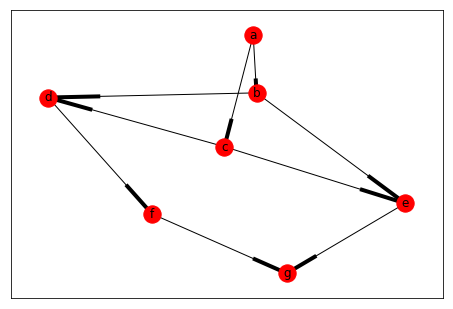

扑排序序列: ['a', 'c', 'b', 'd', 'f', 'e', 'g']
0.14285714285714285


In [58]:
import networkx as nx
import matplotlib.pyplot as plt
DG = nx.DiGraph([('a', 'b'), ('a', 'c'),('b', 'e'), ('b', 'd'),('c', 'e'), ('c', 'd'),('d', 'f'), ('f', 'g'), ('e', 'g')])
nx.draw_spring(DG,with_labels=True) 
plt.axis('on') 
plt.xticks([]) 
plt.yticks([]) 
plt.show() 
print('扑排序序列:',list(nx.topological_sort(DG))) 
print (1/nx.number_of_nodes(DG))